In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster
import leafmap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_2446/3922986243.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/opt/conda/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For

In [2]:
schema = 'projects_research'
table = 'arroyovivo_residuos_hex'
query = f"SELECT * FROM {schema}.{table}"
residuos = aup.gdf_from_query(query, geometry_col='geometry')

print(residuos.shape)
residuos.head(1)

(562, 51)


,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,...,207.0,259.0,89.0,137.0,1.0,1.0,1918.0,Plastico,2669.0,Plastico_quantity


## Estandarización de los datos

In [3]:
coldatos = ['aluminio', 'aluminio_quantity',
       'baterias', 'baterias_quantity', 'carton', 'carton_quantity', 'cenizas',
       'cenizas_quantity', 'ceramica', 'ceramica_quantity', 'electronica',
       'electronica_quantity', 'escombros', 'escombros_quantity', 'goma',
       'goma_quantity', 'llantas', 'llantas_quantity', 'madera',
       'madera_quantity', 'metal', 'metal_quantity', 'organico',
       'organico_quantity', 'otros', 'otros_quantity', 'papel',
       'papel_quantity', 'pesca', 'pesca_quantity', 'plastico',
       'plastico_quantity', 'salud e higiene', 'salud e higiene_quantity',
       'tabaco', 'tabaco_quantity', 'tela', 'tela_quantity', 'unicel',
       'unicel_quantity', 'vidrio', 'vidrio_quantity', 'epi', 'epi_quantity']

# Create a StandardScaler
scaler = StandardScaler()

# Standardize the selected columns
residuos[coldatos] = scaler.fit_transform(residuos[coldatos])
residuos.head()

,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",11.669761,9.057943,-0.103882,-0.084667,13.630210,12.220525,-0.127573,...,18.570515,14.079036,14.658037,12.070278,4.546442,2.893470,1918.0,Plastico,2669.0,Plastico_quantity
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",8.900164,12.544630,-0.103882,-0.084667,4.675946,3.926608,7.838651,...,4.922867,12.915738,4.036645,4.656423,-0.167765,-0.151718,1122.0,Plastico,2473.0,Plastico_quantity
2,8a48a202baaffff,10,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",-0.331826,-0.239891,-0.103882,-0.084667,1.561420,7.072577,-0.127573,...,0.009714,1.892108,0.327587,0.497432,-0.167765,-0.151718,847.0,Plastico,2994.0,Plastico_quantity
3,8a48a202ba1ffff,10,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",2.437771,0.922338,-0.103882,-0.084667,0.004156,-0.077352,-0.127573,...,1.192510,1.227367,8.588670,4.475598,-0.167765,-0.151718,810.0,Plastico,1672.0,Plastico_quantity
4,8a48a202ba0ffff,10,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",0.591373,0.147519,-0.103882,-0.084667,0.393472,0.208646,-0.127573,...,0.919557,1.116576,2.856490,3.209818,-0.167765,-0.151718,708.0,Plastico,1820.0,Plastico_quantity


### Verificar estandarización

In [4]:
print("Media después de estandarización:")
print(residuos[coldatos].mean())

print("\nDesviación estándar después de estandarización:")
print(residuos[coldatos].std())

Media después de estandarización:
aluminio                   -5.057244e-17
aluminio_quantity          -2.528622e-17
baterias                    6.321555e-18
baterias_quantity          -1.264311e-17
carton                      0.000000e+00
carton_quantity             0.000000e+00
cenizas                    -6.321555e-18
cenizas_quantity            0.000000e+00
ceramica                    5.057244e-17
ceramica_quantity          -2.528622e-17
electronica                 0.000000e+00
electronica_quantity       -2.528622e-17
escombros                   2.528622e-17
escombros_quantity          0.000000e+00
goma                        2.528622e-17
goma_quantity               2.528622e-17
llantas                     0.000000e+00
llantas_quantity            0.000000e+00
madera                      2.528622e-17
madera_quantity             0.000000e+00
metal                       2.528622e-17
metal_quantity              0.000000e+00
organico                    2.528622e-17
organico_quantity      

# Dividir DataSet en Material y Quantity

## Material

In [5]:
col_material = ['hex_id', 'res','geometry', 'aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros',
                'goma','llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
                'tabaco','tela','unicel','vidrio','epi','total_points', 'most_common_point'] 
data_material = residuos[col_material].copy()
print(data_material.shape)

(562, 27)


### Res 11

In [6]:
data_material_11 = data_material[data_material['res'] == 11].copy()
print(data_material_11.shape)
data_material_11.head(2)

(420, 27)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,pesca,plastico,salud e higiene,tabaco,tela,unicel,vidrio,epi,total_points,most_common_point
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.331826,-0.103882,1.561420,-0.127573,-0.329080,-0.220429,4.817522,...,-0.134595,2.010942,0.588397,-0.455406,12.467905,0.009714,-0.009600,-0.167765,656.0,Plastico
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",3.360970,-0.103882,2.340051,-0.127573,0.665238,2.257194,-0.034706,...,-0.134595,3.213488,2.034515,-0.455406,2.349179,4.376961,4.879613,-0.167765,517.0,Plastico


#### PCA

In [18]:
colclustering = ['aluminio', 'baterias', 'carton', 'cenizas', 'ceramica', 'electronica',
       'escombros', 'goma', 'llantas', 'madera', 'metal', 'organico', 'otros',
       'papel', 'pesca', 'plastico', 'salud e higiene', 'tabaco', 'tela', 'unicel',
       'vidrio', 'epi']

pca = PCA(n_components=22).fit(data_material_11[colclustering])
new_df = pca.transform(data_material_11[colclustering])
var_exp = pca.explained_variance_ratio_

cumulative_var_exp = np.cumsum(var_exp)
# Find the index where cumulative sum exceeds 70%
components_needed = np.where(cumulative_var_exp >= 0.7)[0][0] + 1

for i in range(components_needed):
    data_material_11[f'PC_{i+1}'] = new_df[:, i]

print(f'Componentes principales necesarios para describir 70% de la varianza: {components_needed} ')

Componentes principales necesarios para describir 70% de la varianza: 8 


#### K-Value Óptimo

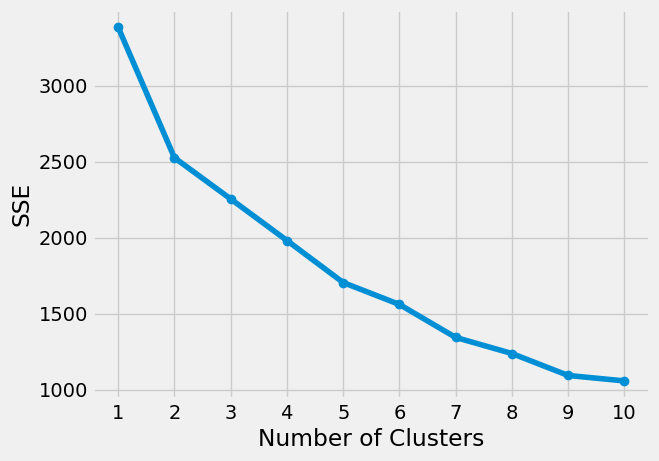

In [22]:
PCA_Material_11 = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8']
kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

sse_11 = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_material_11[PCA_Material_11])
    sse_11.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse_11, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [23]:
kl_11 = KneeLocator(
    range(1, 11), sse_11, curve="convex", direction="decreasing"
)
k_value_11 = kl_11.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {k_value_11}')

El valor óptimo de clusters basado en la data que tenemos es 5


#### K_Means Clúster

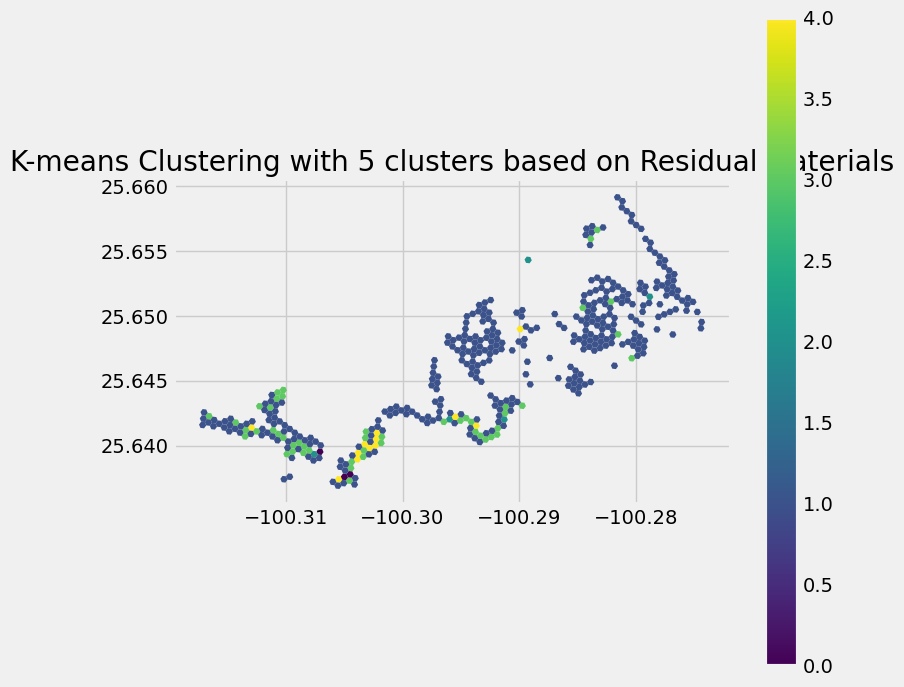

In [24]:
k_11 =  k_value_11


kmeans_11 = KMeans(n_clusters=k_11, **kmeans_kwargs)
data_material_11['cluster'] = kmeans_11.fit_predict(data_material_11[PCA_Material_11])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_material_11.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {k_11} clusters based on Residual Materials')
plt.show()

In [25]:
data_material_11['cluster'].unique()

array([4, 2, 3, 1, 0], dtype=int32)

In [34]:
data_material_11.head(1)

,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,most_common_point,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,cluster
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.331826,-0.103882,1.56142,-0.127573,-0.32908,-0.220429,4.817522,...,Plastico,8.37138,12.333838,-3.87991,-1.867865,-1.003512,2.25628,-3.169405,1.474721,4


#### 3 Materiales Más importantes por Hexágono

In [35]:
imp_var = ['aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros','goma',
           'llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
           'tabaco','tela','unicel','vidrio','epi'] 

#lista_hex = data_material['hex_id'].tolist()
lista_top3_maximos_11 = []
lista_top3_materiales_11 = []
cantidad_filas = data_material_11.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada_11 = data_material_11.iloc[i, 3:-11]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos_11 = sorted(zip(fila_seleccionada_11, imp_var), reverse=True)
    top3_maximos_11 = sorted_residuos_11[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores_11, top3_maximos_materiales_11 = zip(*top3_maximos_11)
    
    lista_top3_maximos_11.append(top3_maximos_valores_11)
    lista_top3_materiales_11.append(top3_maximos_materiales_11)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_material_11['top3_maximos'] = lista_top3_maximos_11
data_material_11['top3_materiales'] = lista_top3_materiales_11
print(data_material_11.shape)
data_material_11.head()

(420, 38)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,cluster,top3_maximos,top3_materiales
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.331826,-0.103882,1.561420,-0.127573,-0.329080,-0.220429,4.817522,...,12.333838,-3.879910,-1.867865,-1.003512,2.256280,-3.169405,1.474721,4,"(12.467904598638627, 10.645422314602298, 4.817...","(tela, papel, escombros)"
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",3.360970,-0.103882,2.340051,-0.127573,0.665238,2.257194,-0.034706,...,-0.169716,-0.042664,-0.134869,0.874754,1.460967,-2.272368,-0.300622,4,"(5.573036867323916, 4.879612724057408, 4.37696...","(metal, vidrio, unicel)"
10,8b48a202ba0afff,11,"POLYGON ((-100.29585 25.64177, -100.29567 25.6...",-0.331826,-0.103882,0.393472,-0.127573,-0.329080,-0.220429,5.874443,...,7.414152,0.587572,-2.682871,0.956749,-3.206831,3.465269,-1.500663,2,"(7.429670248402683, 5.874442697235912, 3.51392...","(pesca, escombros, tela)"
11,8b48a202baa5fff,11,"POLYGON ((-100.29320 25.64050, -100.29302 25.6...",-0.331826,-0.103882,-0.385159,-0.127573,0.665238,-0.220429,9.621708,...,5.797196,-2.663920,-1.267085,0.211801,0.302769,-0.499177,-2.218356,3,"(9.62170797773698, 1.7922978764998465, 1.67633...","(escombros, plastico, vidrio)"
13,8b48a20296a5fff,11,"POLYGON ((-100.30312 25.63985, -100.30294 25.6...",3.360970,-0.103882,2.729367,-0.127573,0.665238,-0.220429,0.061377,...,-0.871253,0.238813,4.828516,0.334525,-1.092145,0.110942,1.328667,4,"(4.546442335675664, 3.4442793450329163, 3.3609...","(epi, plastico, aluminio)"


### Res 10

In [26]:
data_material_10 = data_material[data_material['res'] == 10].copy()
print(data_material_10.shape)
data_material_10.head(2)

(142, 27)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,pesca,plastico,salud e higiene,tabaco,tela,unicel,vidrio,epi,total_points,most_common_point
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",11.669761,-0.103882,13.630210,-0.127573,9.614101,2.257194,0.782005,...,-0.134595,14.206453,13.603459,6.841071,5.843415,18.570515,14.658037,4.546442,1918.0,Plastico
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",8.900164,-0.103882,4.675946,7.838651,1.659556,4.734816,0.974173,...,-0.134595,8.837513,5.408790,3.473467,5.625026,4.922867,4.036645,-0.167765,1122.0,Plastico


#### PCA

In [28]:
pca = PCA(n_components=22).fit(data_material_10[colclustering])
new_df = pca.transform(data_material_10[colclustering])
var_exp = pca.explained_variance_ratio_

cumulative_var_exp = np.cumsum(var_exp)
# Find the index where cumulative sum exceeds 70%
components_needed = np.where(cumulative_var_exp >= 0.7)[0][0] + 1

for i in range(components_needed):
    data_material_10[f'PC_{i+1}'] = new_df[:, i]

print(f'Componentes principales necesarios para describir 70% de la varianza: {components_needed} ')

Componentes principales necesarios para describir 70% de la varianza: 5 


In [29]:
data_material_10.head(2)

,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,unicel,vidrio,epi,total_points,most_common_point,PC_1,PC_2,PC_3,PC_4,PC_5
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",11.669761,-0.103882,13.630210,-0.127573,9.614101,2.257194,0.782005,...,18.570515,14.658037,4.546442,1918.0,Plastico,39.684625,-7.389978,-9.559076,0.843595,-6.591650
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",8.900164,-0.103882,4.675946,7.838651,1.659556,4.734816,0.974173,...,4.922867,4.036645,-0.167765,1122.0,Plastico,21.747294,-0.505405,12.866497,3.258010,-1.101417


#### K-Value Óptimo

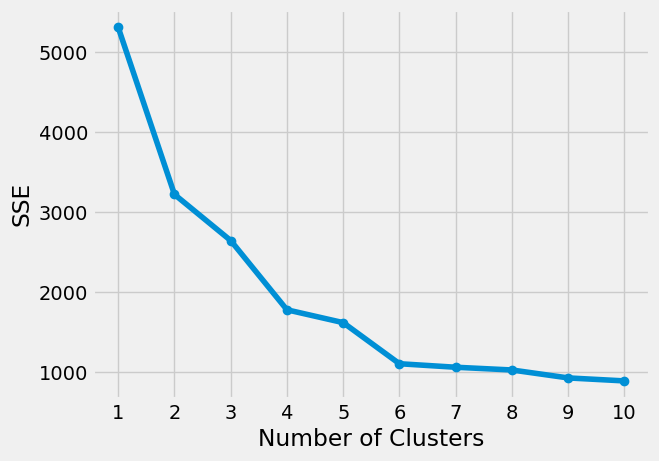

In [30]:
PCA_Material_10 = ['PC_1','PC_2','PC_3','PC_4','PC_5']
kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

sse_10 = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_material_10[PCA_Material_10])
    sse_10.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse_10, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [31]:
kl_10 = KneeLocator(
    range(1, 11), sse_10, curve="convex", direction="decreasing"
)
k_value_10 = kl_10.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {k_value_10}')

El valor óptimo de clusters basado en la data que tenemos es 6


#### K-Means Clúster

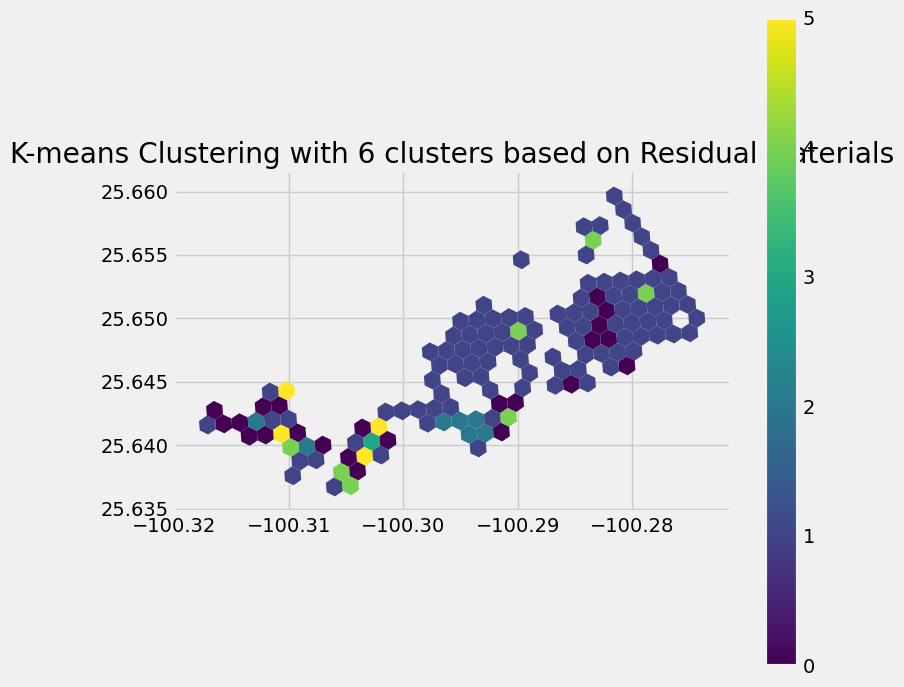

In [32]:
k_10 =  k_value_10


kmeans_10 = KMeans(n_clusters=k_10, **kmeans_kwargs)
data_material_10['cluster'] = kmeans_10.fit_predict(data_material_10[PCA_Material_10])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_material_10.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {k_10} clusters based on Residual Materials')
plt.show()

In [33]:
data_material_10['cluster'].unique()

array([3, 5, 2, 4, 0, 1], dtype=int32)

In [36]:
data_material_10.head(1)

,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,vidrio,epi,total_points,most_common_point,PC_1,PC_2,PC_3,PC_4,PC_5,cluster
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",11.669761,-0.103882,13.63021,-0.127573,9.614101,2.257194,0.782005,...,14.658037,4.546442,1918.0,Plastico,39.684625,-7.389978,-9.559076,0.843595,-6.59165,3


#### 3 Materiales Más importantes por Hexágono

In [37]:
imp_var = ['aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros','goma',
           'llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
           'tabaco','tela','unicel','vidrio','epi'] 

#lista_hex = data_material['hex_id'].tolist()
lista_top3_maximos_10 = []
lista_top3_materiales_10 = []
cantidad_filas = data_material_10.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada_10 = data_material_10.iloc[i, 3:-8]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos_10 = sorted(zip(fila_seleccionada_10, imp_var), reverse=True)
    top3_maximos_10 = sorted_residuos_10[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores_10, top3_maximos_materiales_10 = zip(*top3_maximos_10)
    
    lista_top3_maximos_10.append(top3_maximos_valores_10)
    lista_top3_materiales_10.append(top3_maximos_materiales_10)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_material_10['top3_maximos'] = lista_top3_maximos_10
data_material_10['top3_materiales'] = lista_top3_materiales_10
print(data_material_10.shape)
data_material_10.head()

(142, 35)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,total_points,most_common_point,PC_1,PC_2,PC_3,PC_4,PC_5,cluster,top3_maximos,top3_materiales
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",11.669761,-0.103882,13.630210,-0.127573,9.614101,2.257194,0.782005,...,1918.0,Plastico,39.684625,-7.389978,-9.559076,0.843595,-6.591650,3,"(18.57051480056167, 16.36681740890145, 14.6580...","(unicel, metal, vidrio)"
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",8.900164,-0.103882,4.675946,7.838651,1.659556,4.734816,0.974173,...,1122.0,Plastico,21.747294,-0.505405,12.866497,3.258010,-1.101417,5,"(12.11274753283354, 11.705032175067423, 8.9001...","(otros, llantas, aluminio)"
2,8a48a202baaffff,10,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",-0.331826,-0.103882,1.561420,-0.127573,-0.329080,-0.220429,7.267657,...,847.0,Plastico,6.148539,14.959773,-1.500626,0.541453,-2.774319,2,"(12.322311430885913, 11.459879002101479, 7.267...","(tela, papel, escombros)"
3,8a48a202ba1ffff,10,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",2.437771,-0.103882,0.004156,-0.127573,1.659556,-0.220429,7.940243,...,810.0,Plastico,9.509493,9.360650,-1.225239,0.478453,-3.402049,2,"(9.62735145522832, 8.588670373156496, 7.940242...","(papel, vidrio, escombros)"
4,8a48a202ba0ffff,10,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",0.591373,-0.103882,0.393472,-0.127573,0.665238,-0.220429,7.219615,...,708.0,Plastico,5.384078,9.026510,-1.481489,2.654403,-1.418429,2,"(7.429670248402683, 7.219614849210655, 4.53307...","(pesca, escombros, tela)"


## Quantity

In [39]:
col_qty = ['hex_id', 'res', 'geometry', 'aluminio_quantity', 'baterias_quantity', 'carton_quantity','cenizas_quantity',
                  'ceramica_quantity','electronica_quantity','escombros_quantity','goma_quantity','llantas_quantity', 
                  'madera_quantity','metal_quantity','organico_quantity','otros_quantity','papel_quantity','pesca_quantity',
                  'plastico_quantity','salud e higiene_quantity','tabaco_quantity','tela_quantity','unicel_quantity',
                  'vidrio_quantity','epi_quantity','total_quantity','most_common_quantity'] 
data_quantity = residuos[col_qty].copy()
print(data_quantity.shape)

(562, 27)


### Res 11

In [42]:
data_quantity_11 = data_quantity[data_quantity['res'] == 11].copy()
print(data_quantity_11.shape)
data_quantity_11.head(2)

(420, 27)


,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,pesca_quantity,plastico_quantity,salud e higiene_quantity,tabaco_quantity,tela_quantity,unicel_quantity,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.239891,-0.084667,7.072577,-0.124976,-0.186827,-0.211210,3.988657,...,-0.127573,6.235331,0.229511,-0.383711,12.705014,1.892108,-0.135458,-0.151718,2179.0,Plastico_quantity
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",4.796436,-0.084667,3.926608,-0.124976,0.817927,3.745457,0.214057,...,-0.127573,1.653351,1.322606,-0.383711,1.063107,3.609357,2.757753,-0.151718,734.0,Plastico_quantity


#### PCA

In [44]:
colclust = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

pca = PCA(n_components=22).fit(data_quantity_11[colclust])
new_df = pca.transform(data_quantity_11[colclust])
var_exp = pca.explained_variance_ratio_

cumulative_var_exp = np.cumsum(var_exp)
# Find the index where cumulative sum exceeds 70%
components_needed = np.where(cumulative_var_exp >= 0.7)[0][0] + 1

for i in range(components_needed):
    data_quantity_11[f'PC_{i+1}'] = new_df[:, i]

print(f'Componentes principales necesarios para describir 70% de la varianza: {components_needed} ')

Componentes principales necesarios para describir 70% de la varianza: 9 


In [45]:
data_quantity_11.head(2)

,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,most_common_quantity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.239891,-0.084667,7.072577,-0.124976,-0.186827,-0.211210,3.988657,...,Plastico_quantity,11.644905,12.302244,-5.191968,-0.937116,-2.010828,-0.101793,-3.688801,2.118270,0.276741
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",4.796436,-0.084667,3.926608,-0.124976,0.817927,3.745457,0.214057,...,Plastico_quantity,8.628140,-0.151016,-0.318962,0.333157,-1.386252,0.775548,-1.871391,-1.500545,4.160987


#### K_Value Óptimo

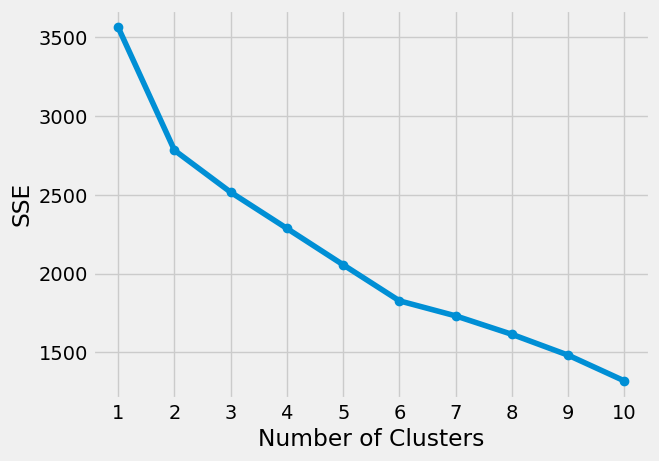

In [52]:
PCA_Quantity_11 = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8','PC_9']

kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

SSE_11 = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_quantity_11[PCA_Quantity_11])
    SSE_11.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), SSE_11, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [53]:
Kl_11 = KneeLocator(
    range(1, 11), SSE_11, curve="convex", direction="decreasing"
)
K_value_11 = Kl_11.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {K_value_11}')

El valor óptimo de clusters basado en la data que tenemos es 3


#### K-Means Clúster

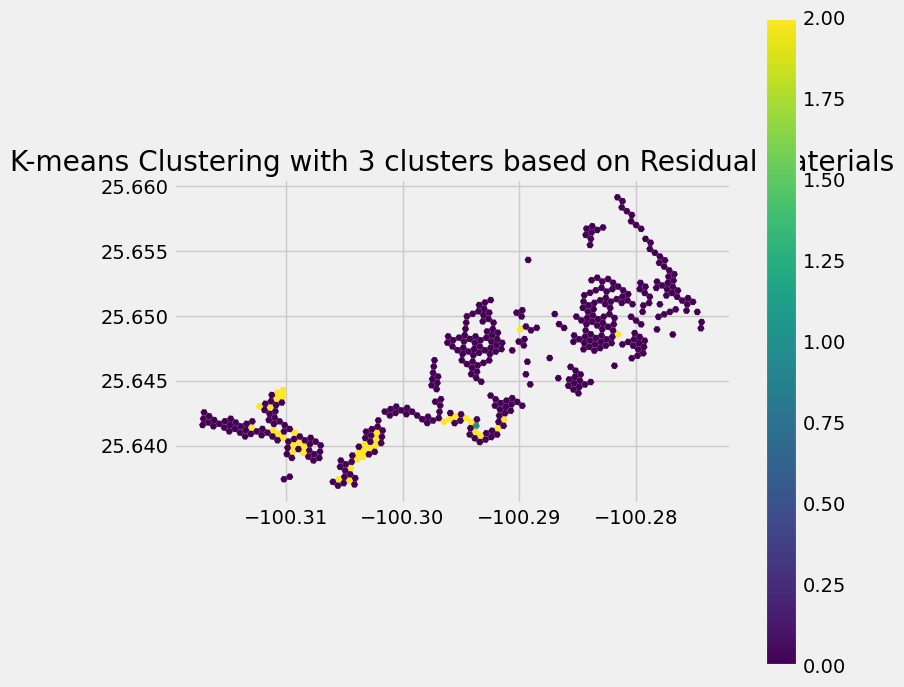

In [54]:
K_11 =  K_value_11


Kmeans_11 = KMeans(n_clusters=K_11, **kmeans_kwargs)
data_quantity_11['cluster'] = Kmeans_11.fit_predict(data_quantity_11[PCA_Quantity_11])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_quantity_11.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {K_11} clusters based on Residual Materials')
plt.show()

In [55]:
data_quantity_11['cluster'].unique()

array([1, 2, 0], dtype=int32)

In [56]:
data_quantity_11.head(1)

,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,cluster,top3_maximos,top3_materiales
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.239891,-0.084667,7.072577,-0.124976,-0.186827,-0.21121,3.988657,...,-5.191968,-0.937116,-2.010828,-0.101793,-3.688801,2.11827,0.276741,1,"(12.705014228416472, 9.24114595714539, 7.07257...","(tela_quantity, papel_quantity, carton_quantity)"


#### 3 Materiales Más importantes por Hexágono

In [57]:
imp_var = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

#lista_hex = data_quantity['hex_id'].tolist()
lista_top3_maximos_11 = []
lista_top3_materiales_11 = []
cantidad_filas = data_quantity_11.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada_11 = data_quantity_11.iloc[i, 3:-12]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos_11 = sorted(zip(fila_seleccionada_11, imp_var), reverse=True)
    top3_maximos_11 = sorted_residuos_11[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores_11, top3_maximos_materiales_11 = zip(*top3_maximos_11)
    
    lista_top3_maximos_11.append(top3_maximos_valores_11)
    lista_top3_materiales_11.append(top3_maximos_materiales_11)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_quantity_11['top3_maximos'] = lista_top3_maximos_11
data_quantity_11['top3_materiales'] = lista_top3_materiales_11
print(data_quantity_11.shape)
data_quantity_11.head()

(420, 39)


,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,cluster,top3_maximos,top3_materiales
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.239891,-0.084667,7.072577,-0.124976,-0.186827,-0.211210,3.988657,...,-5.191968,-0.937116,-2.010828,-0.101793,-3.688801,2.118270,0.276741,1,"(12.705014228416472, 9.24114595714539, 7.07257...","(tela_quantity, papel_quantity, carton_quantity)"
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",4.796436,-0.084667,3.926608,-0.124976,0.817927,3.745457,0.214057,...,-0.318962,0.333157,-1.386252,0.775548,-1.871391,-1.500545,4.160987,2,"(4.7964357008180425, 4.244540769468241, 3.9266...","(aluminio_quantity, papel_quantity, carton_qua..."
10,8b48a202ba0afff,11,"POLYGON ((-100.29585 25.64177, -100.29567 25.6...",-0.239891,-0.084667,0.208646,-0.124976,-0.186827,-0.211210,5.490379,...,-0.592445,-2.472564,3.151569,-0.196104,3.510373,-1.343975,-0.443008,2,"(5.847094763985231, 5.490379438605511, 4.89760...","(pesca_quantity, escombros_quantity, plastico_..."
11,8b48a202baa5fff,11,"POLYGON ((-100.29320 25.64050, -100.29302 25.6...",-0.239891,-0.084667,-0.363349,-0.124976,0.064361,-0.211210,8.412650,...,-2.808329,1.409719,2.013239,-0.550984,1.148129,-2.629124,-3.463011,2,"(8.412650216303783, 3.5075840864316423, 3.2098...","(escombros_quantity, organico_quantity, vidrio..."
13,8b48a20296a5fff,11,"POLYGON ((-100.30312 25.63985, -100.30294 25.6...",1.309748,-0.084667,1.924628,-0.124976,0.064361,-0.211210,-0.029465,...,0.762827,2.298454,0.102125,-0.423405,0.392954,1.280017,0.885056,2,"(2.8934696757583582, 1.9246283511922442, 1.615...","(epi_quantity, carton_quantity, unicel_quantity)"


### Res 10

In [58]:
data_quantity_10 = data_quantity[data_quantity['res'] == 10].copy()
print(data_quantity_10.shape)
data_quantity_10.head(2)

(142, 27)


,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,pesca_quantity,plastico_quantity,salud e higiene_quantity,tabaco_quantity,tela_quantity,unicel_quantity,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",9.057943,-0.084667,12.220525,-0.124976,12.874980,3.745457,1.309909,...,-0.127573,7.436125,9.794093,5.836841,2.268227,14.079036,12.070278,2.893470,2669.0,Plastico_quantity
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",12.544630,-0.084667,3.926608,6.260151,1.069116,9.680458,2.121651,...,-0.127573,8.284055,10.067367,1.689806,3.677989,12.915738,4.656423,-0.151718,2473.0,Plastico_quantity


#### PCA

In [59]:
colclust = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

pca = PCA(n_components=22).fit(data_quantity_10[colclust])
new_df = pca.transform(data_quantity_10[colclust])
var_exp = pca.explained_variance_ratio_

cumulative_var_exp = np.cumsum(var_exp)
# Find the index where cumulative sum exceeds 70%
components_needed = np.where(cumulative_var_exp >= 0.7)[0][0] + 1

for i in range(components_needed):
    data_quantity_10[f'PC_{i+1}'] = new_df[:, i]

print(f'Componentes principales necesarios para describir 70% de la varianza: {components_needed} ')

Componentes principales necesarios para describir 70% de la varianza: 5 


In [61]:
data_quantity_10.head(2)

,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,unicel_quantity,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity,PC_1,PC_2,PC_3,PC_4,PC_5
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",9.057943,-0.084667,12.220525,-0.124976,12.874980,3.745457,1.309909,...,14.079036,12.070278,2.893470,2669.0,Plastico_quantity,32.278692,-3.440479,-9.027659,5.966584,8.350141
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",12.544630,-0.084667,3.926608,6.260151,1.069116,9.680458,2.121651,...,12.915738,4.656423,-0.151718,2473.0,Plastico_quantity,26.034351,-8.685636,11.418255,1.912322,-3.593287


#### K_Value Óptimo

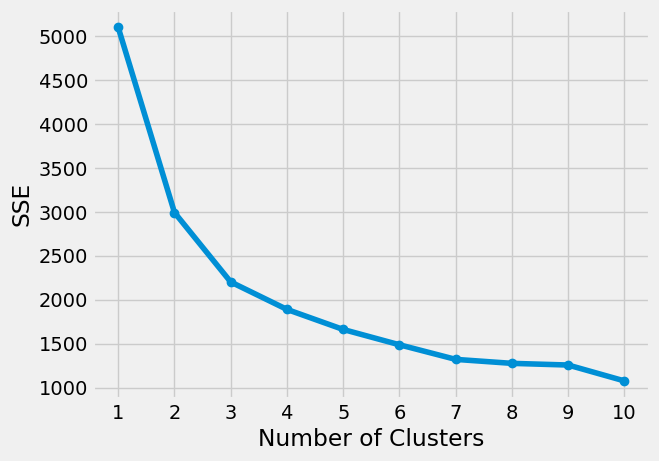

In [62]:
PCA_Quantity_10 = ['PC_1','PC_2','PC_3','PC_4','PC_5']

kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

SSE_10 = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_quantity_10[PCA_Quantity_10])
    SSE_10.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), SSE_10, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [63]:
Kl_10 = KneeLocator(
    range(1, 11), SSE_10, curve="convex", direction="decreasing"
)
K_value_10 = Kl_10.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {K_value_10}')

El valor óptimo de clusters basado en la data que tenemos es 3


#### K-Means Clúster

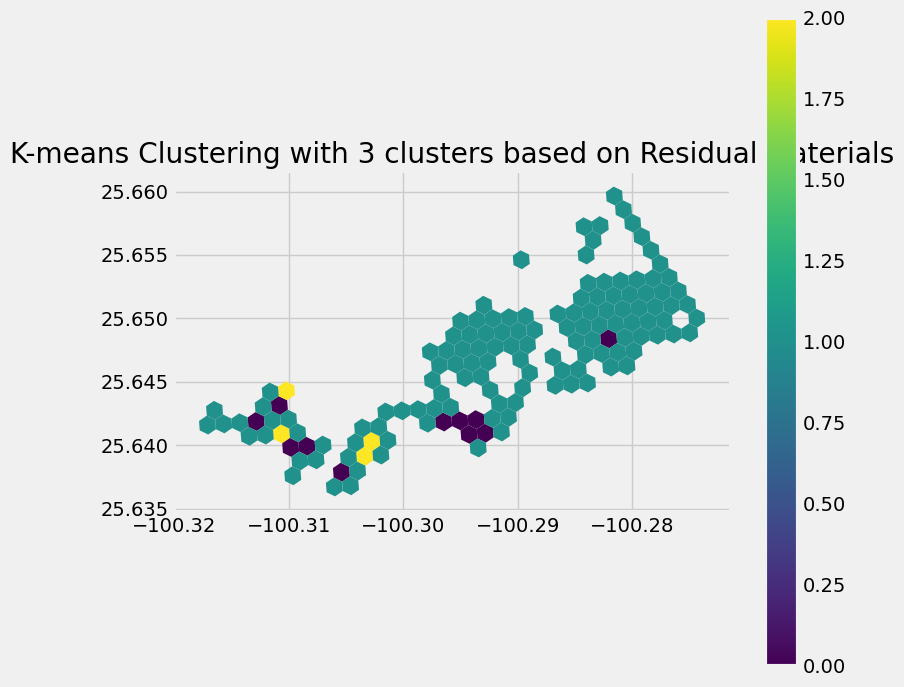

In [64]:
K_10 =  K_value_10


Kmeans_10 = KMeans(n_clusters=K_10, **kmeans_kwargs)
data_quantity_10['cluster'] = Kmeans_10.fit_predict(data_quantity_10[PCA_Quantity_10])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_quantity_10.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {K_10} clusters based on Residual Materials')
plt.show()

In [65]:
data_quantity_10['cluster'].unique()

array([2, 0, 1], dtype=int32)

In [67]:
data_quantity_10.head(2)

,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity,PC_1,PC_2,PC_3,PC_4,PC_5,cluster
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",9.057943,-0.084667,12.220525,-0.124976,12.874980,3.745457,1.309909,...,12.070278,2.893470,2669.0,Plastico_quantity,32.278692,-3.440479,-9.027659,5.966584,8.350141,2
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",12.544630,-0.084667,3.926608,6.260151,1.069116,9.680458,2.121651,...,4.656423,-0.151718,2473.0,Plastico_quantity,26.034351,-8.685636,11.418255,1.912322,-3.593287,2


#### 3 Materiales Más importantes por Hexágono

In [68]:
imp_var = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

#lista_hex = data_quantity['hex_id'].tolist()
lista_top3_maximos_10 = []
lista_top3_materiales_10 = []
cantidad_filas = data_quantity_10.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada_10 = data_quantity_10.iloc[i, 3:-8]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos_10 = sorted(zip(fila_seleccionada_10, imp_var), reverse=True)
    top3_maximos_10 = sorted_residuos_10[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores_10, top3_maximos_materiales_10 = zip(*top3_maximos_10)
    
    lista_top3_maximos_10.append(top3_maximos_valores_10)
    lista_top3_materiales_10.append(top3_maximos_materiales_10)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_quantity_10['top3_maximos'] = lista_top3_maximos_10
data_quantity_10['top3_materiales'] = lista_top3_materiales_10
print(data_quantity_10.shape)
data_quantity_10.head()

(142, 35)


,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,total_quantity,most_common_quantity,PC_1,PC_2,PC_3,PC_4,PC_5,cluster,top3_maximos,top3_materiales
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",9.057943,-0.084667,12.220525,-0.124976,12.874980,3.745457,1.309909,...,2669.0,Plastico_quantity,32.278692,-3.440479,-9.027659,5.966584,8.350141,2,"(16.01231827940748, 14.079035779587196, 12.874...","(metal_quantity, unicel_quantity, ceramica_qua..."
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",12.544630,-0.084667,3.926608,6.260151,1.069116,9.680458,2.121651,...,2473.0,Plastico_quantity,26.034351,-8.685636,11.418255,1.912322,-3.593287,2,"(12.915738149643147, 12.544630193085188, 10.65...","(unicel_quantity, aluminio_quantity, otros_qua..."
2,8a48a202baaffff,10,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",-0.239891,-0.084667,7.072577,-0.124976,-0.186827,-0.211210,6.058599,...,2994.0,Plastico_quantity,10.613006,17.209184,6.952853,2.099907,3.471957,0,"(17.07072932714601, 9.872296086115135, 9.05825...","(tela_quantity, papel_quantity, plastico_quant..."
3,8a48a202ba1ffff,10,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",0.922338,-0.084667,-0.077352,-0.124976,0.315550,-0.211210,6.748579,...,1672.0,Plastico_quantity,7.115254,6.096821,3.694191,-0.933107,0.124680,0,"(7.452887258397779, 6.748579356781156, 5.96673...","(papel_quantity, escombros_quantity, plastico_..."
4,8a48a202ba0ffff,10,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",0.147519,-0.084667,0.208646,-0.124976,0.064361,-0.211210,7.966192,...,1820.0,Plastico_quantity,5.408012,7.471545,3.817369,0.565415,-0.786103,0,"(7.966192180822103, 6.825194652438435, 5.84709...","(escombros_quantity, plastico_quantity, pesca_..."


# Mapa Interactivo

In [71]:
import folium
from folium import GeoJson
import matplotlib.cm as cm
from matplotlib.colors import to_hex

# Create the main map
m = folium.Map(location=[data_quantity_10['geometry'].centroid.y.mean(), data_quantity_10['geometry'].centroid.x.mean()], zoom_start=14.45)

# Quantity Map 1
unique_materials_11_qty = data_quantity_11['cluster'].unique()
color_map_11_qty = cm.get_cmap('Accent', len(unique_materials_11_qty))
color_mapping_11_qty = {material: to_hex(color_map_11_qty(i)) for i, material in enumerate(unique_materials_11_qty)}

def get_color_11_qty(feature):
    material_value = feature['properties']['cluster']
    if material_value == 0:
        return "#f44336"
    elif material_value == 1:
        return "#6aa84f"
    elif material_value == 2:
        return "#8e7cc3"
    elif material_value == 3:
        return "#f2ff00"
    elif material_value == 4:
        return "#c90076"
    elif material_value == 5:
        return "#2986cc"

g_11_qty = folium.plugins.FeatureGroupSubGroup(m, "Quantity Res 11")
m.add_child(g_11_qty)

geojson_layer_11_qty = GeoJson(data_quantity_11, zoom_on_click=True,
                        style_function=lambda feature: {
                            'fillColor': get_color_11_qty(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_quantity','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(g_11_qty)

# Quantity Map 2
unique_materials_10_qty = data_quantity_10['cluster'].unique()
color_map_10_qty = cm.get_cmap('Accent', len(unique_materials_10_qty))
color_mapping_10_qty = {material: to_hex(color_map_10_qty(i)) for i, material in enumerate(unique_materials_10_qty)}

def get_color_10_qty(feature):
    material_value = feature['properties']['cluster']
    if material_value == 0:
        return "#ff0000"
    elif material_value == 1:
        return "#00ff04"
    elif material_value == 2:
        return "#0800ff"
    elif material_value == 3:
        return "#f2ff00"
    elif material_value == 4:
        return "#c90076"
    elif material_value == 5:
        return "#2986cc"

g_10_qty = folium.plugins.FeatureGroupSubGroup(m, "Quantity Res 10")
m.add_child(g_10_qty)

geojson_layer_10_qty = GeoJson(data_quantity_10, zoom_on_click=True,
                        style_function=lambda feature: {
                            'fillColor': get_color_10_qty(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_quantity','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(g_10_qty)

# Material Map 1
unique_materials_11_res = data_material_11['cluster'].unique()
color_map_11_res = cm.get_cmap('Accent', len(unique_materials_11_res))
color_mapping_11_res = {material: to_hex(color_map_11_res(i)) for i, material in enumerate(unique_materials_11_res)}

def get_color_11_res(feature):
    material_value = feature['properties']['cluster']
    if material_value == 0:
        return "#ff0000"
    elif material_value == 1:
        return "#00ff04"
    elif material_value == 2:
        return "#0800ff"
    elif material_value == 3:
        return "#f2ff00"
    elif material_value == 4:
        return "#c90076"
    elif material_value == 5:
        return "#2986cc"

g_11_res = folium.plugins.FeatureGroupSubGroup(m, "Points Res 11")
m.add_child(g_11_res)

geojson_layer_11_res = GeoJson(data_material_11, zoom_on_click=True,
                        style_function=lambda feature: {
                            'fillColor': get_color_11_res(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_point','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(g_11_res)

# Material Map 2
unique_materials_10_res = data_material_10['cluster'].unique()
color_map_10_res = cm.get_cmap('Accent', len(unique_materials_10_res))
color_mapping_10_res = {material: to_hex(color_map_10_res(i)) for i, material in enumerate(unique_materials_10_res)}

def get_color_10_res(feature):
    material_value = feature['properties']['cluster']
    if material_value == 0:
        return "#ff0000"
    elif material_value == 1:
        return "#00ff04"
    elif material_value == 2:
        return "#0800ff"
    elif material_value == 3:
        return "#f2ff00"
    elif material_value == 4:
        return "#c90076"
    elif material_value == 5:
        return "#2986cc"


g_10_res = folium.plugins.FeatureGroupSubGroup(m, "Points Res 10")
m.add_child(g_10_res)

geojson_layer_10_res = GeoJson(data_material_10, zoom_on_click=True,
                        style_function=lambda feature: {
                            'fillColor': get_color_10_res(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_point','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(g_10_res)

# Add custom colormap legend
colormap_legend_html = """
    <div style="position: fixed; bottom: 10px; right: 10px; z-index: 1000; padding: 10px; background-color: rgba(255, 255, 255, 0.7); border-radius: 5px; box-shadow: 0 0 5px rgba(0, 0, 0, 0.2);">
        <p><strong>Número de Clúster</strong></p>
        <p><span style="color: #ff0000;">Rojo</span>: 0</p>
        <p><span style="color: #00ff04;">Verde</span>: 1</p>
        <p><span style="color: #0800ff;">Morado</span>: 2</p>
        <p><span style="color: #f2ff00;">Amarillo</span>: 3</p>
        <p><span style="color: #c90076;">Rosa</span>: 4</p>
        <p><span style="color: #2986cc;">Azul</span>: 5</p>
    </div>
"""

m.get_root().html.add_child(folium.Element(colormap_legend_html))

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

m.save("PCA_KMeans_Arroyo_vivo.html")

# Show the map
m
